### Import python libraries and local functions. 

In [1]:
from glob import glob
import numpy as np
import pyabf
import matplotlib.pyplot as plt
from open_abf import plot_swps, get_sweeps, swp_window, get_protocol, files_from_protocol
from scipy.optimize import leastsq
%matplotlib widget

### Define your path to your data
#### The glob function helps you filter your files

In [2]:
pathToData = "/home/alan/Documents/LAB/CSHL/Data/Good/"
folders = glob(pathToData+"*")
folders

['/home/alan/Documents/LAB/CSHL/Data/Good/20240612_Slice_day_1',
 '/home/alan/Documents/LAB/CSHL/Data/Good/20240608_Na+channel',
 '/home/alan/Documents/LAB/CSHL/Data/Good/20240607_K+channel',
 '/home/alan/Documents/LAB/CSHL/Data/Good/20240610_Ca+channel',
 '/home/alan/Documents/LAB/CSHL/Data/Good/20240611_SingleChannel']

In [3]:
files = glob(folders[1]+"/*.abf")
files

['/home/alan/Documents/LAB/CSHL/Data/Good/20240608_Na+channel/2024_06_07_0003.abf',
 '/home/alan/Documents/LAB/CSHL/Data/Good/20240608_Na+channel/2024_06_07_0004.abf',
 '/home/alan/Documents/LAB/CSHL/Data/Good/20240608_Na+channel/2024_06_07_0005.abf',
 '/home/alan/Documents/LAB/CSHL/Data/Good/20240608_Na+channel/cell001_Na_IV_curve.abf',
 '/home/alan/Documents/LAB/CSHL/Data/Good/20240608_Na+channel/2024_06_07_0006.abf',
 '/home/alan/Documents/LAB/CSHL/Data/Good/20240608_Na+channel/2024_06_07_0000.abf',
 '/home/alan/Documents/LAB/CSHL/Data/Good/20240608_Na+channel/2024_06_07_0001.abf',
 '/home/alan/Documents/LAB/CSHL/Data/Good/20240608_Na+channel/2024_06_07_0002.abf']

In [4]:
get_protocol(files)

['Na IV Curve',
 'Na IV Curve',
 'Steady State Inactivation',
 'Na IV Curve',
 'Recovery from Inactivation Na',
 'Na IV Curve',
 'Steady State Inactivation',
 'Na IV Curve']

### IV curve
#### Choose in your files for the IV protocol.

In [5]:
iv_files = files_from_protocol('IV',files)
iv_files

['/home/alan/Documents/LAB/CSHL/Data/Good/20240608_Na+channel/2024_06_07_0003.abf',
 '/home/alan/Documents/LAB/CSHL/Data/Good/20240608_Na+channel/2024_06_07_0004.abf',
 '/home/alan/Documents/LAB/CSHL/Data/Good/20240608_Na+channel/cell001_Na_IV_curve.abf',
 '/home/alan/Documents/LAB/CSHL/Data/Good/20240608_Na+channel/2024_06_07_0000.abf',
 '/home/alan/Documents/LAB/CSHL/Data/Good/20240608_Na+channel/2024_06_07_0002.abf']

#### plot_swps(f) will show all the sweeps from the recordings

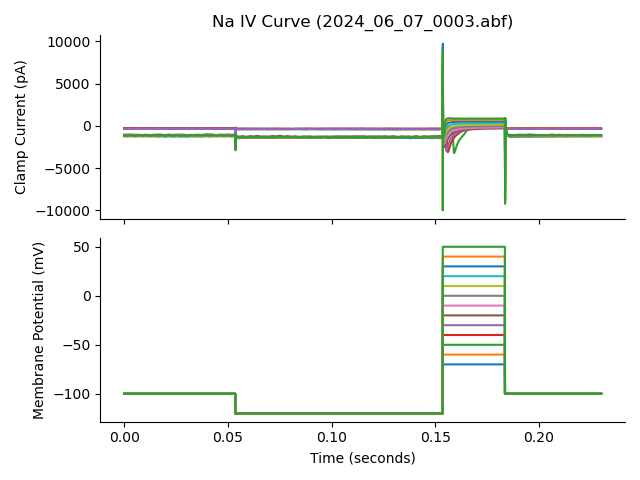

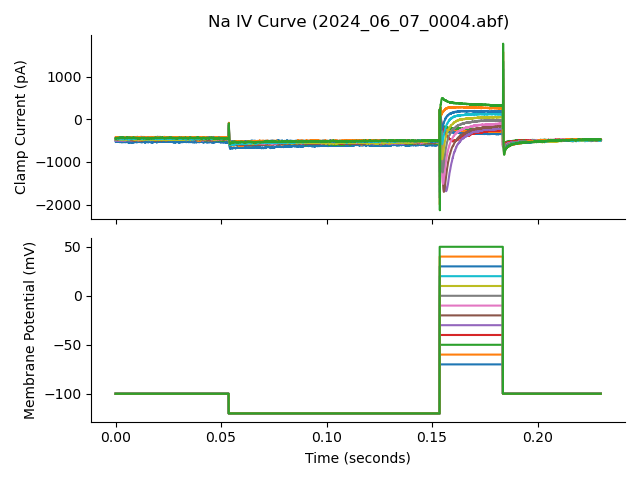

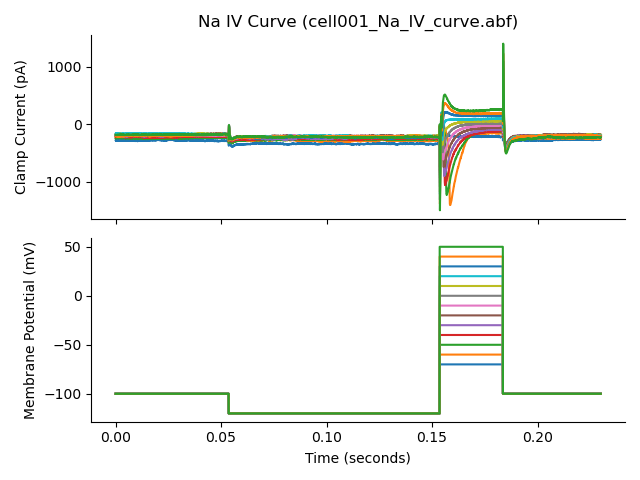

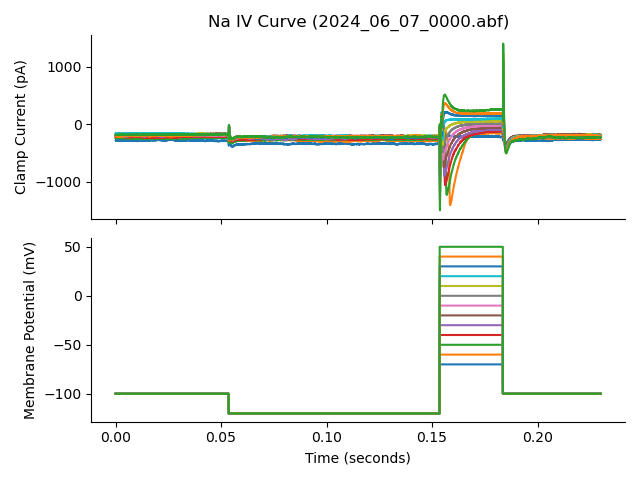

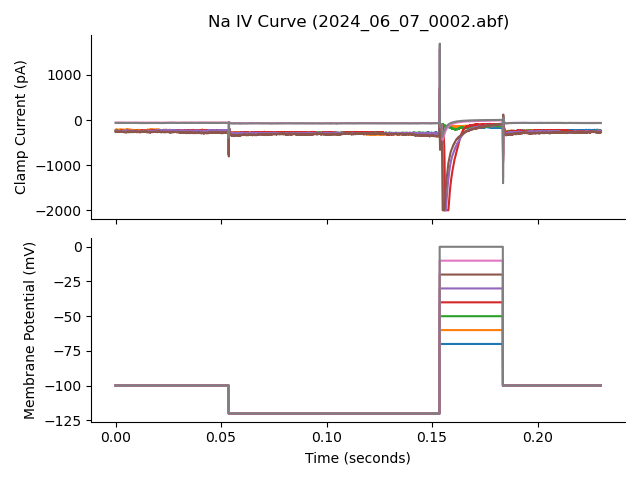

In [6]:
plt.close('all')
for f in iv_files:
    plot_swps(f)

#### get_sweep(f) extract the sweeps from your recording along the time axis (swp_time) and the sampling rate (sr)
#### swps.shape give you the dimensions of your sweeps:
#### (number of sweeps, number of channel, number of point per sweep)

In [6]:
swps, swp_time, sr = get_sweeps(f)
swps.shape

(14, 2, 10000)

### swp_window function will extract the data from the sweeps for a given time window.
#### start and end are in seconds.

In [7]:
def swp_window(swps,start,end,sr,channel=0):
    i_start = int(start * sr)
    i_end = int(end * sr)
    return swps[:,channel,i_start:i_end]

### using numpy (np) functions to:
#### mean (np.mean())
#### max (np.max())
#### min (np.min())
#### The axis parameter gives the dimension on which you apply the function 

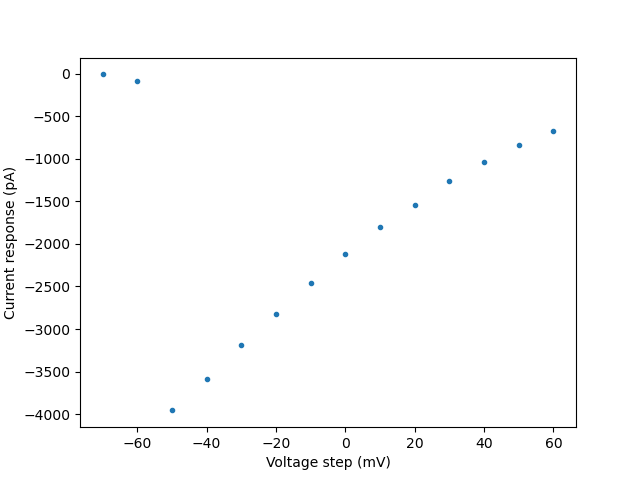

In [8]:
## The mean on your voltage step:
v_start = 0.1135
v_end = 0.14
voltage_step = np.mean(swp_window(swps,v_start,v_end,sr,channel=1),axis=1)
## Baseline current:
i_start = 0.025
i_end = 0.1
current_baseline = np.mean(swp_window(swps,v_start,v_end,sr,channel=0),axis=1)
## the pic response in your current:
i_start = 0.11341
i_end = 0.1155
## This is a little trick to extract the pic amplitude location in absolute values
## and then retreive the "real" value from the original trace.
current_window = swp_window(swps,i_start,i_end,sr,channel=0)
current_response = [swp[np.argmax(np.abs(swp))] for swp in current_window]
# normalise over baseline current
current_response -= current_baseline
## Create a figure plot with this line:
fig,ax = plt.subplots()
## the ax.plot(x,y,'line, dot,...') will plot your data to the figure
ax.plot(voltage_step,current_response,'.')
ax.set_xlabel('Voltage step (mV)')
ax.set_ylabel('Current response (pA)')
plt.show()

### Activation Curve

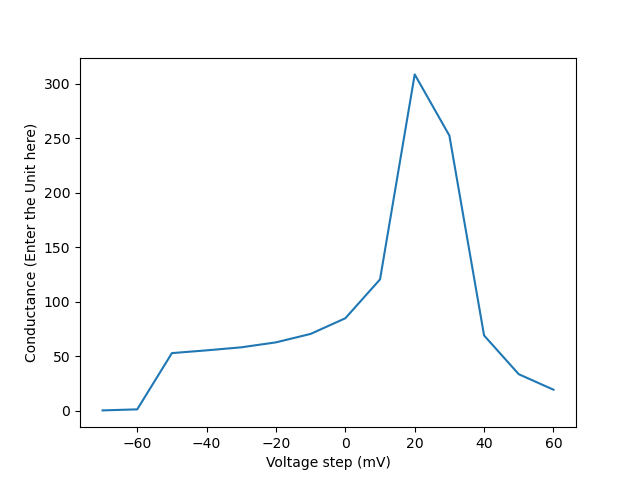

In [9]:
## reversal potential in mV from the IV Curve:
E_rev = 25
## Calculate conductance.
conductance = current_response/(voltage_step - E_rev)
## Plot the result.
fig, ax = plt.subplots()
ax.plot(voltage_step,abs(conductance))
ax.set_xlabel('Voltage step (mV)')
ax.set_ylabel('Conductance (Enter the Unit here)')
plt.show()

### Normalise  

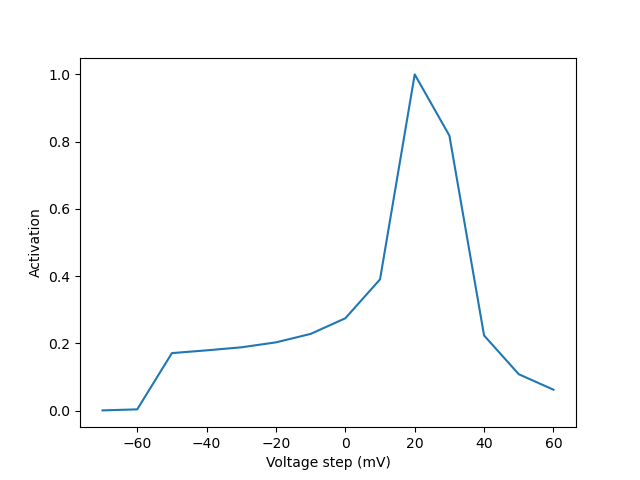

In [10]:
conductance = np.abs(conductance) ## Conductance are positive values.
activation = conductance/conductance.max()
fig, ax = plt.subplots()
ax.plot(voltage_step,activation)
ax.set_xlabel('Voltage step (mV)')
ax.set_ylabel('Activation')
plt.show()

#### Then we want to fit the activation curve with a Boltzman function:

In [11]:
def fun_boltz(x, p):
    """Fit function for growth: single exponential + offset
    p[0] : V 50
    p[1] : slope
    """
    return 1.0 - (1.0/(1.0+np.exp((x-p[0])/p[1])))

def minimize_fun(p, x, y):
    return y-fun_boltz(x, p)

v50_init = 0.0
slope_init = 1.0
x = voltage_step
y = activation
p_guess = (v50_init,slope_init)
fit_boltz = leastsq(minimize_fun, p_guess, args=(x, y),full_output=True)
fit_params = fit_boltz[0]
print(fit_boltz[0])
fit_fun = fun_boltz(x,fit_params)
ax.plot(x,fit_fun,label=f"fit\n slope={fit_params[1]}\n V50={fit_params[0]} ")
ax.legend()

[90.252  97.7953]


### Recovery rotocols

In [26]:
files = glob(folders[1]+"/*reco*")
files

['/home/alan/Documents/LAB/CSHL/Data/Nav/24607007_reco-100.abf',
 '/home/alan/Documents/LAB/CSHL/Data/Nav/24607010_reco-110.abf',
 '/home/alan/Documents/LAB/CSHL/Data/Nav/24607008-reco-90.abf']

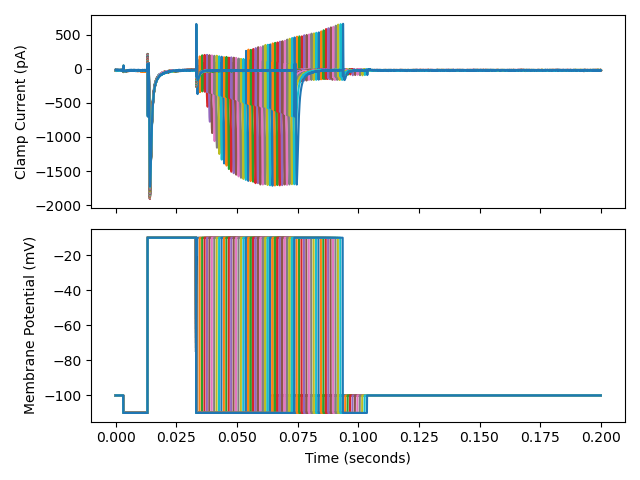

In [27]:
f = files[1]
plot_swps(f)

### Check the stability of your reference current response from the activation step:

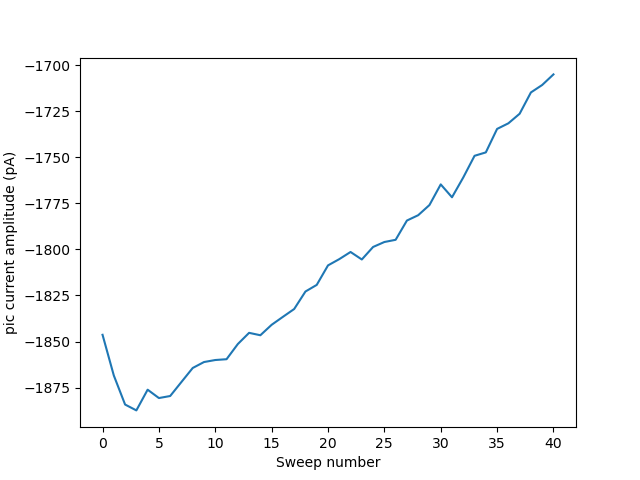

In [14]:
swps, swp_time, sr = get_sweeps(f)
## Baseline current:
i_start = 0.004
i_end = 0.012
current_baseline = np.mean(swp_window(swps,v_start,v_end,sr,channel=0),axis=1)
## Reference current:
i_start = 0.013
i_end = 0.016
## Correct  with baseline.
ref_current = np.min(swp_window(swps,i_start,i_end,sr,channel=0),axis=1) - current_baseline
fig, ax = plt.subplots()
ax.plot(ref_current)
ax.set_xlabel('Sweep number')
ax.set_ylabel('pic current amplitude (pA)')
plt.show()

### Create the time interval array from your protocol: 

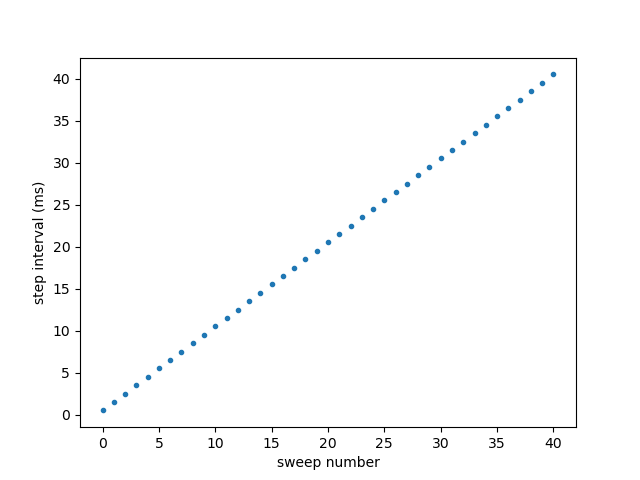

In [15]:
nb_sweep = len(swps)
first_interval = 0.5 # ms
interval = 1 #ms
time_int = np.arange(nb_sweep)*interval + first_interval
fig,ax = plt.subplots()
ax.plot(time_int,'.')
ax.set_xlabel('sweep number')
ax.set_ylabel('step interval (ms)')
plt.show()

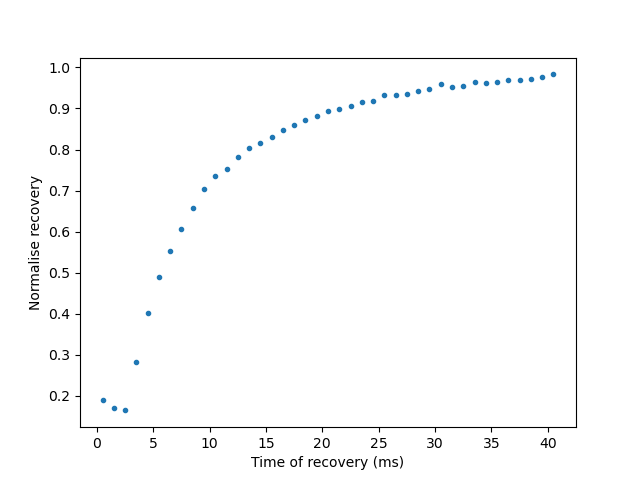

In [16]:
## Then Extract the pic currents
## If the Cp compensation is good you can take the same whole window for all the currents.
i_start = 0.0335
i_end = 0.08
reco_current = np.min(swp_window(swps,i_start,i_end,sr,channel=0),axis=1) - current_baseline
fig,ax = plt.subplots()
ax.plot(time_int,reco_current/ref_current,'.',label='data')
ax.set_xlabel('Time of recovery (ms)')
ax.set_ylabel('Normalise recovery')
plt.show()

### Lets fit this to an exponential decay function 

In [17]:
def fun_exp(t, p):
    """Fit function for decay: single exponential + offset (amplitude is one because it's normalised)
    p[0] : tau
    p[1] : offset
    """
    return 1 - (np.exp(-t/p[0])+ p[1])

def minimize_fun(p, x, y):
    return y-fun_exp(x, p)

x = time_int
y = reco_current/ref_current
## INITIAL CONDITIONS ARE CRITICAL !
tau = 1
offset = 0
p_guess = [tau,offset]
fit_exp = leastsq(minimize_fun, p_guess, args=(x, y),full_output=True)
fit_exp

(array([8.0002, 0.0195]),
 array([[117.6174,  -2.7661],
        [ -2.7661,   0.0894]]),
 {'fvec': array([ 0.1479,  0.0193, -0.0841, ...,  0.0005,  0.0032,  0.0088]),
  'nfev': 25,
  'fjac': array([[-6.4031,  0.1562,  0.1562, ...,  0.1562,  0.1562,  0.1562],
         [-0.1506,  0.0922, -0.0786, ...,  0.1783,  0.1833,  0.1879]]),
  'ipvt': array([2, 1], dtype=int32),
  'qtf': array([-0., -0.])},
 'Both actual and predicted relative reductions in the sum of squares\n  are at most 0.000000',
 1)

In [18]:
fit_params = fit_exp[0]
fit_params

array([8.0002, 0.0195])

In [19]:
fit_fun = fun_exp(x,fit_params)
ax.plot(x,fit_fun,label=f"fit trace / tau={round(fit_params[0],2)} ms")
ax.legend(loc="lower right")

### Inactivation Protocol

In [20]:
files = glob(folders[1]+"/*inact*")
files

['/home/alan/Documents/LAB/CSHL/Data/Nav/24607006_inact.abf']

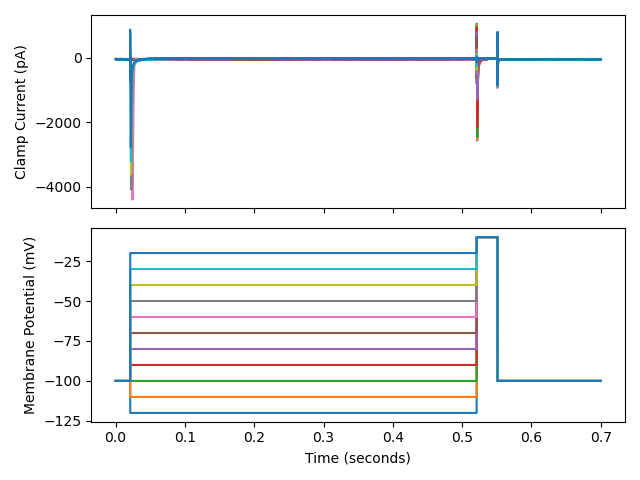

In [21]:
plt.close('all')
f = files[0]
plot_swps(f)

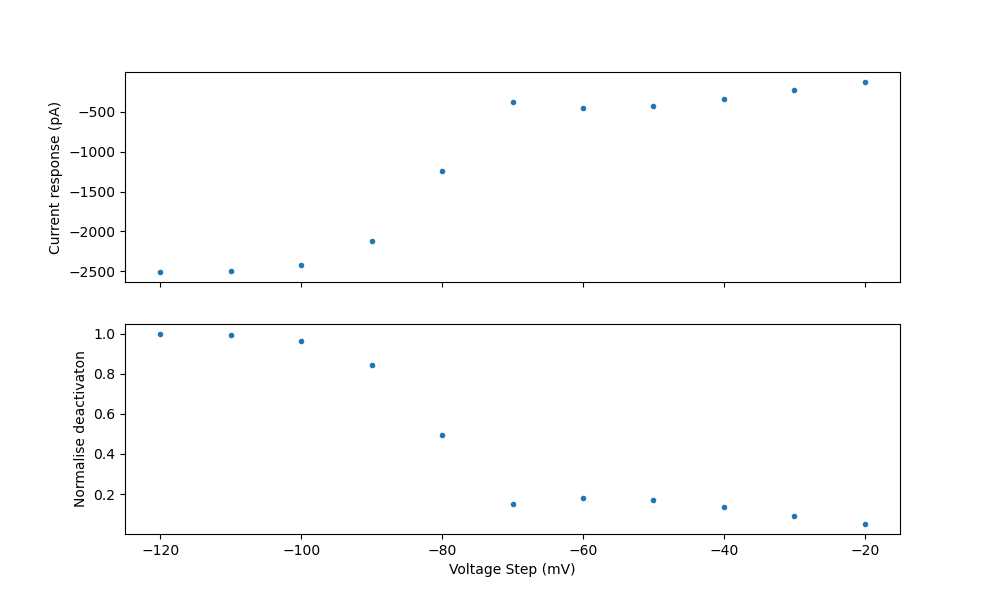

In [22]:
## Get the sweeps
swps, swp_time, sr = get_sweeps(f)
## define your voltage step window channel 1
v_start = 0.1135
v_end = 0.52
voltage_step = np.mean(swp_window(swps,v_start,v_end,sr,channel=1),axis=1)
## Current baseline
i_start = 0.1
i_end = 0.5
current_baseline = np.mean(swp_window(swps,v_start,v_end,sr,channel=0),axis=1)
## define your current step window channel 0
i_start = 0.1
i_end = 0.523
current_response = np.min(swp_window(swps,i_start,i_end,sr,channel=0),axis=1) - current_baseline
## Create a figure with two subplots (ax[0] and ax[1])
## The sharex=True makes the two subplots share the same x axis. 
fig,ax = plt.subplots(2,sharex=True,figsize=(10,6))
ax[0].plot(voltage_step,current_response,'.')
ax[0].set_ylabel('Current response (pA)')
ax[1].plot(voltage_step,current_response/current_response.min(),'.')
ax[1].set_ylabel('Normalise deactivaton')
ax[1].set_xlabel('Voltage Step (mV)')
plt.show()

### Lets fit a Boltzman function 

In [23]:
def fun_boltz(x, p):
    """Fit function for decay
    p[0] : V 50
    p[1] : slope
    """
    return 1.0/(1.0+np.exp((x-p[0])/p[1]))

def minimize_fun(p, x, y):
    return y-fun_boltz(x, p)

## INITIAL CONDITIONS ARE CRITICAL !
v50_init = 0.0
slope_init = 1.0
##
x = voltage_step
y = current_response/current_response.min()
p_guess = (v50_init,slope_init)
fit_boltz = leastsq(minimize_fun, p_guess, args=(x, y),full_output=True)
fit_boltz

(array([-79.2489,   8.16  ]),
 array([[489.5664,   0.0038],
        [  0.0038, 380.2823]]),
 {'fvec': array([0.0067, 0.0145, 0.0353, ..., 0.1284, 0.0888, 0.0482]),
  'nfev': 128,
  'fjac': array([[-0.0513,  0.1987,  0.4107, ..., -0.0922, -0.0344, -0.0122],
         [ 0.    ,  0.0452,  0.1764, ...,  0.0233,  0.007 ,  0.0021]]),
  'ipvt': array([2, 1], dtype=int32),
  'qtf': array([-0.,  0.])},
 'Both actual and predicted relative reductions in the sum of squares\n  are at most 0.000000',
 1)

In [24]:
fit_params = fit_boltz[0]
print(fit_boltz[0])
fit_fun = fun_boltz(x,fit_params)
ax[1].plot(x,fit_fun,label=f"fit\n slope={fit_params[1]}\n V50={fit_params[0]} ")
ax[1].legend()

[-79.2489   8.16  ]


###  I you get to this point This can Help you when you are lazy

In [25]:
def Nernst(cIN,cOUT,z):
    R = 8.3144598
    T = 298.15
    F = 9.64853321233100184e4
    nernst = ((R*T)/(z*F))*np.log(cOUT/cIN)
    return nernst*1e3
# low external Sodium
Nernst(10,105.,1)

60.412874361331575